In [59]:
import time
import win32gui
import numpy as np

import mss
import mss.tools
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from cloningCNN import CloningCNN, ResNet

from torch.distributions import Categorical

from pynput.keyboard import Key, Controller
import matplotlib.pyplot as plt

# Define RL environment for the game window

In [60]:
class GameEnv:
    def __init__(self, windowName, inputInterval):
        self.gameBbox = self.getWindowBbox(windowName)
        self.capper = mss.mss()
        self.capNum = 0
        self.downsamplingMethod = Image.NEAREST
        
        self.captureWindow = None
        self.prevGoldPixels = None
        self.prevLvlPixels = None
        
        self.keyboard = Controller()
        self.keyCodes = {0:Key.up, 1:Key.right, 2:Key.down, 3:Key.left}
        self.inputInterval = inputInterval
        
    def getWindowBbox(self, windowName):
        gameWindow = win32gui.FindWindow(None, windowName)
        if gameWindow == 0:
            print("Could not find game window for \"" + windowName + "\". Exiting.")
            exit()
        
        bbox = list(win32gui.GetWindowRect(gameWindow))
        # fix idiosyncrasies of win32gui window rect acquisition
        bbox[0] += 8
        bbox[1] += 31
        width = bbox[2]-bbox[0]
        height = bbox[3]-bbox[1]
        # return a 'monitor' object in the format that the mss library wants
        return {'top': bbox[1], 'left': bbox[0], 'width': width-8, 'height': height-8}
    
    def quickRestart(self):
        for key in [Key.esc, Key.up, Key.up, Key.up, Key.right]:
            self.keyboard.press(key)
            self.keyboard.release(key)
            time.sleep(0.1)
        time.sleep(1)
    
    def reset(self):
        self.quickRestart()
        initScreen, initGoldPixels, initLvlPixels, heartPixels = self.getScreenInfo()
        self.prevGoldPixels = initGoldPixels
        self.prevLvlPixels = initLvlPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow = [initScreen for _ in range(4)]
        
        return self.captureWindow
    
    def getScreenInfo(self):
        # capture screen and downscale to 180x180
        self.capNum += 1
        screenCap = self.capper.grab(self.gameBbox)
        img = Image.frombytes('RGB', screenCap.size, screenCap.bgra, 'raw', 'BGRX')
#         padded = ImageOps.expand(img, (30,38,26,18))
#         resized = padded.resize((360,360), self.downsamplingMethod)
        final = img.resize((224,224), self.downsamplingMethod)
        
        # check screen for reward indicators
        goldPixels = np.array(final.crop((201,7,218,15))) == 255 # white pixels of gold meter in top right
        goldPixels = goldPixels.astype(int)
        
        lvlPixels = np.array(final.crop((219,219,224,224))) == 255
        lvlPixels = lvlPixels.astype(int)
        
        heartPixels = []
        for pixelCoord in [153,158,170,175]:
            heartPixels.append(np.array(final.crop((pixelCoord,10,pixelCoord+1,11))).sum())

        return (final, goldPixels, lvlPixels, heartPixels)
    
    def step(self, action):
        done = False
        reward = 0
        
        # carry out action
        keyPress = self.keyCodes[action]
        self.keyboard.press(keyPress)
        self.keyboard.release(keyPress)
        
        # wait, then get new game capture
        time.sleep(self.inputInterval)
        screen, goldPixels, lvlPixels, heartPixels = self.getScreenInfo()
        
        # check if got reward
        if np.sum(np.abs(goldPixels - self.prevGoldPixels)) != 0: # gold value changed
            reward += 10
        if np.sum(np.abs(lvlPixels - self.prevLvlPixels)) != 0: # beat level 1
            reward += 100
            done = True
            
        # check for damage or dead
        for heartIndex, heartPixel in enumerate(heartPixels):
            if self.prevHeartPixels[heartIndex] != 115 and heartPixel == 115:
                reward -= 10
                print ("lost heart {}. penalty applied.".format(heartIndex))
        if heartPixels[0] == 115:
            done = True
            
        # update state variables
        self.prevGoldPixels = goldPixels
        self.prevLvlPixels = lvlPixels
        self.prevHeartPixels = heartPixels
        self.captureWindow.pop()
        self.captureWindow.insert(0, screen)
        
        return (self.captureWindow, reward, done)

# Define Agent with CNN

In [61]:
class CloningAgent:
    def __init__(self, paramsFile, gamma=0.99):
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            print("using cuda")
        else:
            self.device = torch.device('cpu')
#         self.cloningCNN = CloningCNN('deeper', dropout=0.5, inChannels=12)
        self.cloningCNN = ResNet()
        self.cloningCNN.load_state_dict(torch.load(paramsFile))
        self.cloningCNN.eval()
        self.cloningCNN = self.cloningCNN.to(device=self.device)
        self.normTransform = self.getNormTransform()
        
        self.saved_log_probs = []
        self.rewards = []
        self.gamma = gamma
        
        self.eps = np.finfo(np.float32).eps.item()
        self.optimizer = optim.Adam(self.cloningCNN.parameters(), lr=1e-4)
        
    def getNormTransform(self):
        meanImage = np.load("data/stats/dsetMean_ResNet.npy")
        stdImage = np.load("data/stats/dsetStd_ResNet.npy")
        plt.subplot(121)
        plt.imshow(np.array(np.round(meanImage), dtype=np.uint8))
        plt.title("Mean image")
        plt.subplot(122)
        plt.imshow(np.array(np.round(stdImage), dtype=np.uint8))
        plt.title("Std image")
        # get channel means formatted like tensors
        channelMeans = meanImage.transpose((2,0,1)).mean(axis=(1,2)) / 255
        channelStds = meanImage.transpose((2,0,1)).std(axis=(1,2)) / 255

        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(channelMeans, channelStds)
        ])
        
    def getActionScores(self, state, verbose=False):
        tensors = [self.normTransform(cap).unsqueeze(0) for cap in state]
        x = torch.cat((tensors[0],tensors[1],tensors[2],tensors[3]), dim=1)
        x = x.to(device=self.device, dtype=torch.float32)  # move to device, e.g. GPU
        actionScores = self.cloningCNN(x)   #.data.cpu().numpy()[0]
        if verbose:
            print(actionScores)
        return actionScores

    def sampleAction(self, state, verbose=False):
        scores = self.getActionScores(state, verbose)
        probs = F.softmax(scores, dim=1)
        m = Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()
    
    def finishEpisode(self):
        R = 0
        policy_loss = []
        rewards = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            rewards.insert(0, R)
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + self.eps)
        for log_prob, reward in zip(self.saved_log_probs, rewards):
            policy_loss.append(-log_prob * reward)
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()
        del self.rewards[:]
        del self.saved_log_probs[:]

using cuda


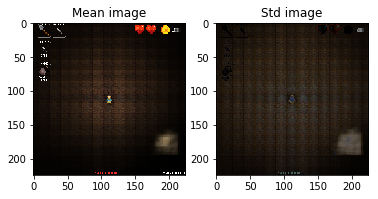

In [62]:
windowName = "Crypt of the NecroDancer"
env = GameEnv(windowName, 0.4)
agent = CloningAgent("models/ResnetQuadsVal80.pt")

In [ ]:
running_reward = 20
log_interval = 10
rewardsOverTime = []

In [ ]:
print("Move the windows taskbar!")
time.sleep(4) # activate the game window during this
for i_episode in range(800):
    state = env.reset()
    t, timeSinceReward, totalReward = 0, 0, 0
    while timeSinceReward < 100:  # Don't infinite loop while learning
        action = agent.sampleAction(state, verbose=(t%100==0))
        state, reward, done = env.step(action)
        if reward != 0:
            timeSinceReward = 0
            totalReward += reward
            print("Got reward {}.".format(reward))
        agent.rewards.append(reward)
        aborted = win32gui.GetWindowText(win32gui.GetForegroundWindow()) != windowName
        if aborted or done:
            break
        timeSinceReward += 1
        t += 1
    if aborted:
        print("Game window no longer active. Stopping training.")
        break
    
    print('finishing episode...')
    running_reward = running_reward * 0.95 + t * 0.05
    agent.finishEpisode()
    rewardsOverTime.append(totalReward)
    
    
    if i_episode % log_interval == 0:
        print('Episode {}\tLast reward: {:5d}\tAverage reward: {:.2f}'.format(
            i_episode, totalReward, running_reward))
        torch.save(agent.cloningCNN.state_dict(), "models/PG_preinit/{}.pt".format(i_episode))
    

In [ ]:
plt.plot(rewardsOverTime)
plt.axis([0, 135, -40, 200])
plt.show()

In [ ]:
avgs = []
N = 25
for i in range(N):
    avgs.append(0)
for i in range(N, len(rewardsOverTime)):
    avgs.append(sum(rewardsOverTime[i-N:i])/N)
plt.figure(dpi=300)
plt.plot(avgs)
plt.plot(rewardsOverTime)
plt.axis([0, 120, -40, 200])
plt.savefig('foo.png')
plt.show()


# Run the model greedily after training

In [73]:
print("Move the windows taskbar!")
with torch.no_grad():
    time.sleep(4) # activate the game window during this
    state = env.reset()
    while win32gui.GetWindowText(win32gui.GetForegroundWindow()) == windowName: # exit on window unfocus
        actionScores = agent.getActionScores(state)
#         print(actionScores)
        action = np.argmax(actionScores.data.cpu().numpy()[0])
        state, reward, done = env.step(action)
#         time.sleep(0.4)
        if reward != 0:
            print("Got reward {}.".format(reward))
        
print("Game window no longer active. Exiting.")

Move the windows taskbar!
lost heart 2. penalty applied.
lost heart 3. penalty applied.
Got reward -20.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
Got reward 10.
lost heart 0. penalty applied.
lost heart 1. penalty applied.
Got reward -20.
Game window no longer active. Exiting.
